## 背景介绍:

我们每天会接触不同的人，有热情的面孔，也有冰冷的名片。作为一个说着中国话的中国人，我们有着常年累月的积累和对文字的理解，通过名字判断（猜测）性别，并非难事。可是，对于一个冰冷的机器，它能够根据名字判断性别吗？这个练习赛就是根据中文名字（姓已经省略），判断性别

In [1]:
# 读取文件

import pandas as pd
from collections import defaultdict
import math

# 读取train.txt
train = pd.read_csv(r'./data/train.txt')
test = pd.read_csv(r'./data/test.txt')
submit = pd.read_csv(r'./data/sample_submit.csv')

In [3]:
train.head(10)

,id,name,gender
0,1,闳家,1
1,2,玉璎,0
2,3,于邺,1
3,4,越英,0
4,5,蕴萱,0
5,6,子颀,0
6,7,靖曦,0
7,8,鲁莱,1
8,9,永远,1
9,10,红孙,1


In [4]:
# 把数据分为男女两部分
names_female = train[train['gender'] == 0]
names_male = train[train['gender'] == 1]

# totals用来存放训练集中女生、男生的总数
totals = {'f': len(names_female),
          'm': len(names_male)}

分别计算在所有女生（男生）的名字当中，某个字出现的频率。这一步相当于是计算 P(Xi|女生)和P(Xi|男生)

In [5]:
frequency_list_f = defaultdict(int)
for name in names_female['name']:
    for char in name:
        frequency_list_f[char] += 1. / totals['f']

frequency_list_m = defaultdict(int)
for name in names_male['name']:
    for char in name:
        frequency_list_m[char] += 1. / totals['m']

In [7]:
print('娟: %.6f%%, 钢: %.6f%%'%(frequency_list_f['娟']*100,frequency_list_m['钢']*100))

娟: 0.414401%, 钢: 0.062997%


上面两个例子说明P(名字中含有娟|女生)=0.004144，P(名字中含有钢|男生)=0.0006299
考虑到预测集中可能会有汉字并没有出现在训练集中，所以我们需要对频率进行Laplace平滑（什么是Laplace平滑）。

In [8]:
def LaplaceSmooth(char, frequency_list, total, alpha=1.0):
    count = frequency_list[char] * total
    distinct_chars = len(frequency_list)
    freq_smooth = (count + alpha ) / (total + distinct_chars * alpha)
    return freq_smooth

In [9]:
base_f = math.log(1 - train['gender'].mean())
base_f += sum([math.log(1 - frequency_list_f[char]) for char in frequency_list_f])

base_m = math.log(train['gender'].mean())
base_m += sum([math.log(1 - frequency_list_m[char]) for char in frequency_list_m])

bases = {'f': base_f, 'm': base_m}
bases

{'f': -2.7979656779961717, 'm': -2.5689473462479535}

对于logP(Xi=1|Y)−logP(Xi=0|Y)部分，我们利用如下函数计算

In [13]:
def GetLogProb(char, frequency_list, total):
    freq_smooth = LaplaceSmooth(char, frequency_list, total)
    return math.log(freq_smooth) - math.log(1 - freq_smooth)

In [14]:
def ComputeLogProb(name, bases, totals, frequency_list_m, frequency_list_f):
    logprob_m = bases['m']
    logprob_f = bases['f']
    for char in name:
        logprob_m += GetLogProb(char, frequency_list_m, totals['m'])
        logprob_f += GetLogProb(char, frequency_list_f, totals['f'])
    return {'male': logprob_m, 'female': logprob_f}

def GetGender(LogProbs):
    return LogProbs['male'] > LogProbs['female']

result = []
for name in test['name']:
    LogProbs = ComputeLogProb(name, bases, totals, frequency_list_m, frequency_list_f)
    gender = GetGender(LogProbs)
    result.append(int(gender))

submit['gender'] = result

submit.to_csv('my_NB_prediction.csv', index=False)

## 高频单字划分法(Python)
该模型预测结果的准确度为：0.70509

In [2]:
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

# 划分数据集
X_train,X_test=train_test_split(train,random_state=42)

# 所有男生的名字
train_male = X_train[X_train['gender'] == 1]
names_male = "".join(train_male['name'])

# 所有女生的名字
train_female = X_train[X_train['gender'] == 0]
names_female = "".join(train_female['name'])

# 所有男生的名字中频率最高的250个字top_chars_male
# 所有女生的名字中频率最高的250个字top_chars_female
n_top = 250
#lists_male = map(lambda x: x.encode('utf-8'), names_male.decode('utf-8'))
counts_male = Counter(names_male).most_common(n_top)
top_chars_male = []
for [x, y] in counts_male:
    top_chars_male.append(x)
#lists_female = map(lambda x: x.encode('utf-8'), names_female.decode('utf-8'))
counts_female = Counter(names_female).most_common(n_top)
top_chars_female = []
for [x, y] in counts_female:
    top_chars_female.append(x)
    
# 去除top_chars_male和top_chars_female中重复的字
intersects=set(top_chars_male)&set(top_chars_female)
top_chars_male = set(top_chars_male) - intersects
top_chars_female = set(top_chars_female) - intersects

# 如果名字中包含top_chars_male中的字，那么预测性别为男
# 否则查看名字中包含top_chars_female中的字，如果有，则预测性别为女
# 再则，随机设置一个性别
import warnings
warnings.filterwarnings('ignore')
preds=[]
for i in X_test.index:
    if any(s in X_test.loc[i,'name'] for s in top_chars_male):
        preds.append(1)#X_test.loc[i,'name'] = 1
    elif any(s in X_test.loc[i,'name'] for s in top_chars_female):
        preds.append(0)
    else:
        preds.append(np.random.choice(2))

In [4]:
X_test["preds"]=preds
X_test.head(10)

,id,name,gender,preds
71787,71788,卓仁,1,1
67218,67219,勋平,1,1
54066,54067,允,0,1
7168,7169,莹蓝,0,0
29618,29619,妆戆,0,1
101425,101426,中红,1,1
20441,20442,悛耀,1,1
2662,2663,丽凤,0,0
20371,20372,荑宁,0,0
108151,108152,鸣闪,1,1


              precision    recall  f1-score   support

           0       0.67      0.72      0.69     13299
           1       0.76      0.71      0.74     16701

   micro avg       0.72      0.72      0.72     30000
   macro avg       0.71      0.72      0.72     30000
weighted avg       0.72      0.72      0.72     30000

精确度: 0.7169333333333333


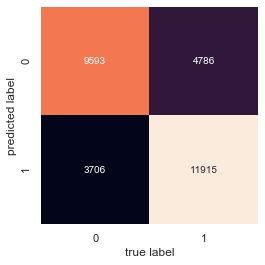

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def print_result(col1='gender',col2='preds'):
    print(classification_report(X_test[col1], X_test[col2]))#,
    #                            target_names=[0,1]))
    print("精确度:",accuracy_score(X_test[col1], X_test[col2]))

    mat = confusion_matrix(X_test[col1], X_test[col2])
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=[0,1],
                yticklabels=[0,1])
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.ylim([2,0])
    
print_result('gender','preds')

## 基于TF的GBDT模型(Python)

该模型预测结果的准确度为：0.83361

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

m_cnt = len(train_male)
f_cnt = len(train_female)
counts_male = Counter(names_male)
counts_female = Counter(names_female)

# 得到训练集中每个人的每个字的词频（Term Frequency，通常简称TF）
train_encoded = []
for i in X_train.index:
    chs = X_train.loc[i, 'name']
    row = [0., 0., 0., 0, X_train.loc[i, 'gender']]
    for j in range(len(chs)):
        row[2* j] = counts_female[chs[j]] * 1. / f_cnt
        row[2* j + 1] = counts_male[chs[j]] * 1. / m_cnt
    train_encoded.append(row)

# 得到测试集中每个人的每个字的词频（Term Frequency，通常简称TF）
test_encoded = []
for i in X_test.index:
    chs = X_test.loc[i, 'name']
    row = [0., 0., 0., 0.,]
    for j in range(len(chs)):
        try:
            row[2 * j] = counts_female[chs[j]] * 1. / f_cnt
        except:
            pass
        try:
            row[2 * j + 1] = counts_male[chs[j]] * 1. / m_cnt
        except:
            pass
    test_encoded.append(row)

# 转换为pandas.DataFrame的形式
# 1_f是指这个人的第一个字在训练集中所有女生的字中出现的频率
# 2_f是指这个人的第二个字在训练集中所有女生的字中出现的频率
# 1_m是指这个人的第一个字在训练集中所有男生的字中出现的频率
# 2_m是指这个人的第二个字在训练集中所有男生的字中出现的频率
train_encoded = pd.DataFrame(train_encoded, columns=['1_f', '1_m', '2_f', '2_m', 'gender'])
test_encoded = pd.DataFrame(test_encoded, columns=['1_f', '1_m', '2_f', '2_m'])

# 训练GBDT模型
clf = GradientBoostingClassifier()
clf.fit(train_encoded.drop('gender', axis=1), train_encoded['gender'])
preds = clf.predict(test_encoded)

print('finished.')

finished.


In [19]:
X_test["preds_1"]=preds
X_test.head(10)

,id,name,gender,preds,preds_1
71787,71788,卓仁,1,1,1
67218,67219,勋平,1,1,1
54066,54067,允,0,1,0
7168,7169,莹蓝,0,0,0
29618,29619,妆戆,0,1,0
101425,101426,中红,1,1,1
20441,20442,悛耀,1,1,1
2662,2663,丽凤,0,0,0
20371,20372,荑宁,0,0,0
108151,108152,鸣闪,1,1,1


              precision    recall  f1-score   support

           0       0.83      0.77      0.80     13299
           1       0.83      0.88      0.85     16701

   micro avg       0.83      0.83      0.83     30000
   macro avg       0.83      0.82      0.83     30000
weighted avg       0.83      0.83      0.83     30000

精确度: 0.83


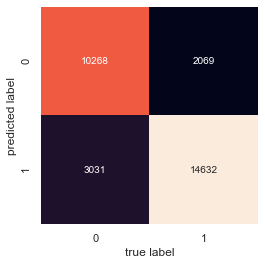

In [21]:
print_result('gender','preds_1')

In [24]:
# 拉普拉斯平滑
def LaplaceSmooth(char, frequency_list, total, alpha=1.0):
    count = frequency_list[char] * total
    distinct_chars = len(frequency_list)
    freq_smooth = (count + alpha ) / (total + distinct_chars * alpha)
    return freq_smooth

In [25]:
# 得到训练集中每个人的每个字的词频（Term Frequency，通常简称TF）
train_encoded = []
for i in X_train.index:
    chs = X_train.loc[i, 'name']
    row = [0., 0., 0., 0, X_train.loc[i, 'gender']]
    for j in range(len(chs)):
        row[2* j] = LaplaceSmooth(chs[j],counts_female,f_cnt)#counts_female[chs[j]] * 1. / f_cnt
        row[2* j + 1] = LaplaceSmooth(chs[j],counts_male,m_cnt)#counts_male[chs[j]] * 1. / m_cnt
    train_encoded.append(row)

# 得到测试集中每个人的每个字的词频（Term Frequency，通常简称TF）
test_encoded = []
for i in X_test.index:
    chs = X_test.loc[i, 'name']
    row = [0., 0., 0., 0.,]
    for j in range(len(chs)):
        try:
            row[2 * j] = LaplaceSmooth(chs[j],counts_female,f_cnt)
        except:
            pass
        try:
            row[2 * j + 1] = LaplaceSmooth(chs[j],counts_male,m_cnt)
        except:
            pass
    test_encoded.append(row)

# 转换为pandas.DataFrame的形式
# 1_f是指这个人的第一个字在训练集中所有女生的字中出现的频率
# 2_f是指这个人的第二个字在训练集中所有女生的字中出现的频率
# 1_m是指这个人的第一个字在训练集中所有男生的字中出现的频率
# 2_m是指这个人的第二个字在训练集中所有男生的字中出现的频率
train_encoded = pd.DataFrame(train_encoded, columns=['1_f', '1_m', '2_f', '2_m', 'gender'])
test_encoded = pd.DataFrame(test_encoded, columns=['1_f', '1_m', '2_f', '2_m'])

# 训练GBDT模型
clf = GradientBoostingClassifier()
clf.fit(train_encoded.drop('gender', axis=1), train_encoded['gender'])
preds = clf.predict(test_encoded)

print('LaplaceSmooth finished.')

LaplaceSmooth finished.


In [26]:
X_test["preds_2"]=preds
X_test.head(10)

,id,name,gender,preds,preds_1,preds_2
71787,71788,卓仁,1,1,1,1
67218,67219,勋平,1,1,1,1
54066,54067,允,0,1,0,0
7168,7169,莹蓝,0,0,0,0
29618,29619,妆戆,0,1,0,0
101425,101426,中红,1,1,1,1
20441,20442,悛耀,1,1,1,1
2662,2663,丽凤,0,0,0,0
20371,20372,荑宁,0,0,0,0
108151,108152,鸣闪,1,1,1,1


              precision    recall  f1-score   support

           0       0.83      0.77      0.80     13299
           1       0.83      0.88      0.85     16701

   micro avg       0.83      0.83      0.83     30000
   macro avg       0.83      0.82      0.83     30000
weighted avg       0.83      0.83      0.83     30000

精确度: 0.8309


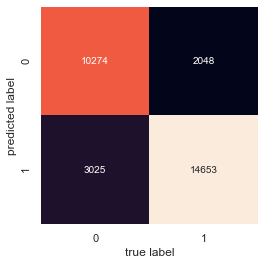

In [27]:
print_result('gender','preds_2')

In [1]:
#import numpy as np
def caculate_kappa(lst):
    #lst=np.array(lst).reshape(2,2)
    a,b,c,d=lst[0],lst[1],lst[2],lst[3]
    kappa=((a+d)/(a+b+c+d)-((a+b)*(a+c)+(b+d)*(c+d))/(a+b+c+d)**2)/(1-((a+b)*(a+c)+(b+d)*(c+d))/(a+b+c+d)**2)
    return kappa

In [4]:
caculate_kappa([10274,3025,2048,14653])

0.6548114225206988